In [1]:
import numpy as np
from netCDF4 import Dataset
import xarray as xr
import h5py
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os

DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

TRAIN_MONTHS = pd.date_range(start='1981-01-01', end='2014-12-01', freq='MS')
VAL_MONTHS = pd.date_range(start='2015-01-01', end='2018-12-01', freq='MS')
TEST_MONTHS = pd.date_range(start='2019-01-01', end='2024-06-01', freq='MS')

def read_hdf5_file(data_path, data_name):
    with h5py.File(data_path, 'r') as f:
        return f[data_name][()]

def load_pickle(load_path):
    with open(load_path, 'rb') as file:
        data = pickle.load(file)
    return data

def calc_masked_MSE_loss(outputs, targets, target_months, use_weights=False, zero_class_weight=None):
    ice_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/monthly_ice_mask.nc").mask

    n_active_cells = 0

    for target_months_subset in target_months:
        n_active_cells += ice_mask.sel(month=target_months_subset).sum().values
    
    # Punish predictions of sea ice in ice free zones 
    if use_weights:
        weights = np.where(targets == 0, zero_class_weight, 1)
        loss = np.sum(((targets - outputs) ** 2) * weights) / n_active_cells
    else:
        loss = np.sum((targets - outputs) ** 2) / n_active_cells

    return loss

def anomaly_persistence(start_prediction_month, predict_anomalies=False):
    """
    The anomaly persistence baseline model 
    """

    siconc_anom = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/normalized_inputs/siconc_anom.nc").siconc
    siconc_clim = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/siconc_clim.nc").siconc
    land_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/land_mask.nc").mask
    siconc_anom *= ~land_mask

    anomaly_to_persist = siconc_anom.sel(time=start_prediction_month - pd.DateOffset(months=1)) 
    months_to_predict_clim = siconc_clim.sel(month=pd.date_range(start_prediction_month, \
        start_prediction_month+pd.DateOffset(months=5), freq='MS').month)

    prediction = months_to_predict_clim + anomaly_to_persist 

    # clip unphysical values outside of [0, 1] 
    prediction = prediction.where(prediction < 1, 1)
    prediction = prediction.where(prediction > 0, 0)

    if predict_anomalies:
        prediction = prediction - months_to_predict_clim

    return prediction

def generate_start_prediction_months(max_month_lead_time=6, max_input_lag_time=12):
    # Construct the date range for the data pairs 
    # Note that this is not continuous due to the missing data in 1987-1988 
    first_range = pd.date_range('1981-01', pd.Timestamp('1987-12') - pd.DateOffset(months=max_month_lead_time+1), freq='MS')
    second_range = pd.date_range(pd.Timestamp('1988-01') + pd.DateOffset(months=max_input_lag_time+1), '2024-01', freq='MS')

    return first_range.append(second_range)

prediction_months = generate_start_prediction_months()

val_start_index = prediction_months.get_loc(VAL_MONTHS[0])

# Load in truth sea ice data
nsidc_sic = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc")
land_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/land_mask.nc").mask
sic_land_masked = nsidc_sic.siconc.where(~land_mask, 0)

siconc_clim = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/siconc_clim.nc").siconc
siconc_clim = siconc_clim.where(~land_mask, 0)

# Load in the predicted data 
val_preds_anom = np.zeros((5, 48, 6, 336, 320))
val_preds_abs = np.zeros((5, 48, 6, 336, 320))
for seed in range(5):
    val_preds_anom[seed,:,:,:,:] = np.load(f"{DATA_DIRECTORY}/sicpred/val_predictions/UNetRes3_all_sicanom_{seed}_val_predictions.npy")
    val_preds_abs[seed,:,:,:,:] = np.load(f"{DATA_DIRECTORY}/sicpred/val_predictions/UNetRes3_all_{seed}_val_predictions.npy")

val_targets = h5py.File(f"{DATA_DIRECTORY}/sicpred/data_pairs_npy/targets_anom_regression.h5")["targets_sea_ice_only"]

val_preds_anom_ds = xr.Dataset(
    data_vars=dict(
        siconc=(["ens_member", "init_month", "lead", "y", "x"], val_preds_anom[:,:,:,2:-2,2:-2]),
    ),
    coords=dict(
        y=("y", nsidc_sic.ygrid.data),
        x=("x", nsidc_sic.xgrid.data),
        init_month=VAL_MONTHS - pd.DateOffset(months=1),
        lead=np.arange(1,7,1),
        ens_member=np.arange(5)
    )
)

val_preds_abs_ds = xr.Dataset(
    data_vars=dict(
        siconc=(["ens_member", "init_month", "lead", "y", "x"], val_preds_abs[:,:,:,2:-2,2:-2]),
    ),
    coords=dict(
        y=("y", nsidc_sic.ygrid.data),
        x=("x", nsidc_sic.xgrid.data),
        init_month=VAL_MONTHS - pd.DateOffset(months=1),
        lead=np.arange(1,7,1),
        ens_member=np.arange(5)
    )
)


# Plot an example of anomaly prediction model

Text(0.5, 0.98, 'Init month = 2017-9')

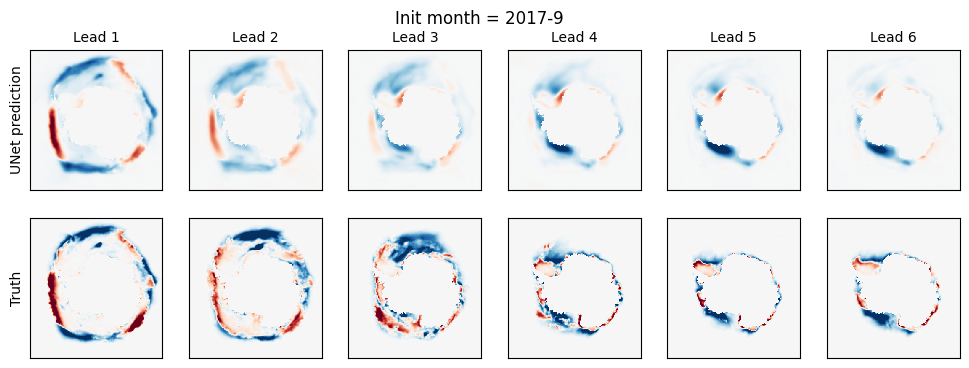

In [133]:
xgrid = nsidc_sic.xgrid / 1e6
ygrid = nsidc_sic.ygrid / 1e6

val_time_index = 33
true_time_index = val_start_index+val_time_index
fig, axs = plt.subplots(figsize=(12,4), nrows=2, ncols=6, sharex=True, sharey=True)

for i in range(6):
    val_pred_ensemble_average = val_preds_anom[:,val_time_index,i,2:-2,2:-2].mean(axis=0)

    axs[0,i].pcolormesh(xgrid, ygrid, val_pred_ensemble_average, cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    axs[1,i].pcolormesh(xgrid, ygrid, val_targets[true_time_index,i,:,:], cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    axs[1,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_yticks([])
    axs[0,i].set_title(f"Lead {i+1}", fontsize=10)

axs[0,0].set_ylabel("UNet prediction")
axs[1,0].set_ylabel("Truth")
init_month = prediction_months[true_time_index-1]
plt.suptitle(f"Init month = {init_month.year}-{init_month.month}")
#plt.savefig(f"../figures/sample_predictions/anomaly_prediction_example.jpg", dpi=300, bbox_inches='tight')

Text(0.5, 0.94, 'Init month = 2015-8')

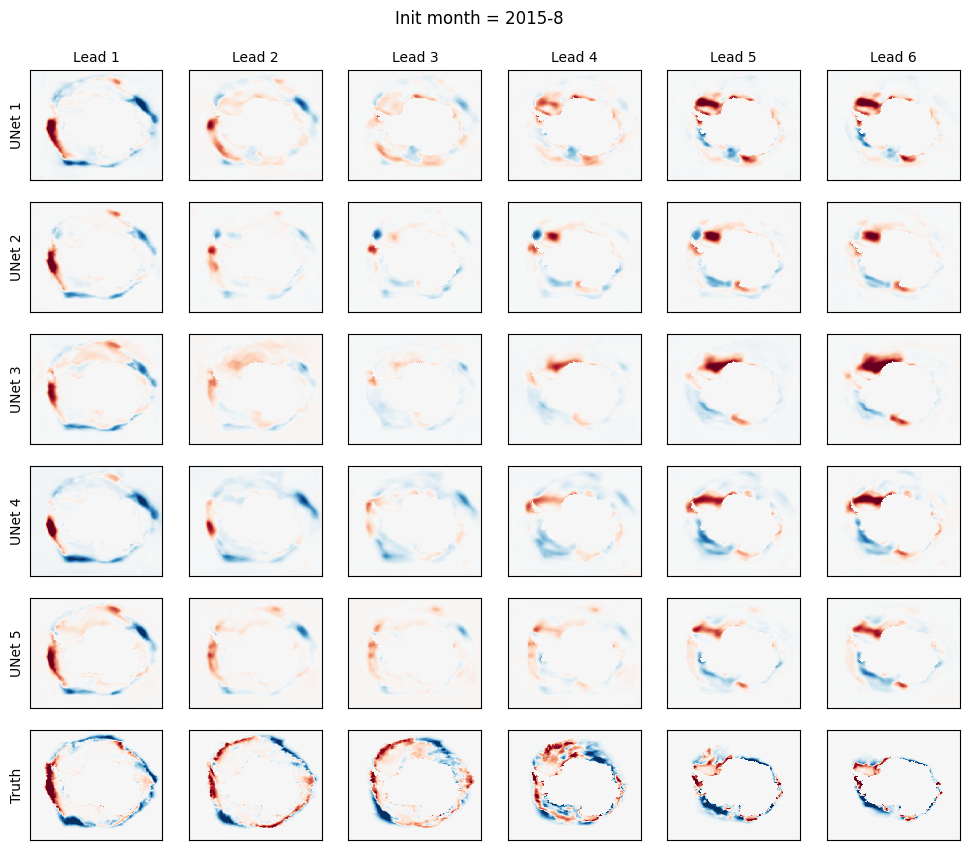

In [150]:
xgrid = nsidc_sic.xgrid / 1e6
ygrid = nsidc_sic.ygrid / 1e6

val_time_index = 8
true_time_index = val_start_index+val_time_index
fig, axs = plt.subplots(figsize=(12,10), nrows=6, ncols=6, sharex=True, sharey=True)

for i in range(6):
    for j in range(5):
        val_pred_ensemble_average = val_preds_anom[j,val_time_index,i,2:-2,2:-2]

        axs[j,i].pcolormesh(xgrid, ygrid, val_pred_ensemble_average, cmap='RdBu_r', vmin=-0.4, vmax=0.4)
        axs[j,i].set_yticks([])
        axs[j,0].set_ylabel(f"UNet {j+1}")

    axs[0,i].set_title(f"Lead {i+1}", fontsize=10)
    axs[5,i].pcolormesh(xgrid, ygrid, val_targets[true_time_index,i,:,:], cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    axs[5,i].set_xticks([])
    axs[5,i].set_yticks([])

axs[5,0].set_ylabel("Truth")
init_month = prediction_months[true_time_index-1]
plt.suptitle(f"Init month = {init_month.year}-{init_month.month}", y=0.94)
#plt.savefig(f"../figures/sample_predictions/anom_pred_ensemble_example_confidentcorrect.jpg", dpi=300, bbox_inches='tight')

# Calculate model errors by month and lead time

In [18]:

mae_by_month_and_lead_anom = np.zeros((12, 6))
mae_by_month_and_lead_abs = np.zeros((12, 6))
nmae_by_month_and_lead_anom = np.zeros((12, 6))
nmae_by_month_and_lead_abs = np.zeros((12, 6))

cell_area = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/NSIDC_SPS_grid_areas.nc").cell_area

for lead in range(1,7): 
    prediction_times = VAL_MONTHS - pd.DateOffset(months=1) + pd.DateOffset(months=lead)
    for target_month in range(1,13):
        # get prediction for anomaly forecast
        val_pred_ens_mean_anom = val_preds_anom_ds.siconc.sel(lead=lead).mean('ens_member')

        init_month = (target_month - lead - 1) % 12 + 1
        val_pred_subset_anom = val_pred_ens_mean_anom.where(val_pred_ens_mean_anom.init_month.dt.month==init_month, drop=True)

        # Add anomaly to climatology to retrieve true sea ice 
        val_pred_subset_anom += siconc_clim.sel(month=target_month)
        val_pred_subset_anom = val_pred_subset_anom.where(val_pred_subset_anom < 1, 1)
        val_pred_subset_anom = val_pred_subset_anom.where(val_pred_subset_anom > 0, 0)
        
        # get prediction for abs forecast
        val_pred_ens_mean_abs = val_preds_abs_ds.siconc.sel(lead=lead).mean('ens_member')
        val_pred_subset_abs = val_pred_ens_mean_abs.where(val_pred_ens_mean_abs.init_month.dt.month==init_month, drop=True)

        # get truth 
        truth = sic_land_masked.sel(time=prediction_times)
        truth = truth.where(truth.time.dt.month==target_month, drop=True)

        # calculate mean error over all times in val set 
        
        sia_truth = (truth * cell_area).sum(dim=("x", "y")) / 1e12
        sia_pred_anom = (val_pred_subset_anom * cell_area).sum(dim=("x", "y")) / 1e12
        sia_pred_abs = (val_pred_subset_abs * cell_area).sum(dim=("x", "y")) / 1e12

        mae_by_month_and_lead_anom[target_month-1, lead-1] = np.abs(sia_pred_anom.values - sia_truth.values).mean()
        mae_by_month_and_lead_abs[target_month-1, lead-1] = np.abs(sia_pred_abs.values - sia_truth.values).mean()

        # get the percent error 
        nmae_by_month_and_lead_anom[target_month-1, lead-1] = np.abs((sia_pred_anom.values - sia_truth.values)/sia_truth.values).mean()
        nmae_by_month_and_lead_abs[target_month-1, lead-1] = np.abs((sia_pred_abs.values - sia_truth.values)/sia_truth.values).mean()



In [93]:
# do the persistence forecast
anomaly_persistence_pred = np.zeros((len(VAL_MONTHS), 6, 332, 316))
for i, start_prediction_month in enumerate(VAL_MONTHS):
    anomaly_persistence_pred[i,:,:,:] = anomaly_persistence(start_prediction_month).values

val_preds_persist_ds = xr.Dataset(
    data_vars=dict(
        siconc=(["init_month", "lead", "y", "x"], anomaly_persistence_pred),
    ),
    coords=dict(
        y=("y", nsidc_sic.ygrid.data),
        x=("x", nsidc_sic.xgrid.data),
        init_month=VAL_MONTHS - pd.DateOffset(months=1),
        lead=np.arange(1,7,1),
    )
)

# retrieve the linear forecast
linear_forecast = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/linear_forecasts/linear_forecast_all_years.nc").siconc
linear_forecast = linear_forecast.rename({"xgrid": "x", "ygrid": "y"})
linear_forecast = linear_forecast.where(~land_mask, 0)



In [97]:
# calculate the same metrics for anomaly persistence and linear 
mae_by_month_and_lead_persist = np.zeros((12, 6))
nmae_by_month_and_lead_persist = np.zeros((12, 6))

for lead in range(1,7): 
    prediction_times = VAL_MONTHS - pd.DateOffset(months=1) + pd.DateOffset(months=lead)
    for target_month in range(1,13):
        init_month = (target_month - lead - 1) % 12 + 1
        val_pred_persist_subset = val_preds_persist_ds.siconc.sel(lead=lead)
        val_pred_persist_subset = val_pred_persist_subset.where(val_pred_persist_subset.init_month.dt.month==init_month, drop=True)

        # get truth 
        truth = sic_land_masked.sel(time=prediction_times)
        truth = truth.where(truth.time.dt.month==target_month, drop=True)

        sia_truth = (truth * cell_area).sum(dim=("x", "y")) / 1e12
        sia_pred_persist = (val_pred_persist_subset * cell_area).sum(dim=("x", "y")) / 1e12

        mae_by_month_and_lead_persist[target_month-1, lead-1] = np.abs(sia_pred_persist.values - sia_truth.values).mean()
        nmae_by_month_and_lead_persist[target_month-1, lead-1] = np.abs((sia_pred_persist.values - sia_truth.values)/sia_truth.values).mean()

mae_by_month_and_lead_lin = np.zeros((12, 6))
nmae_by_month_and_lead_lin = np.zeros((12, 6))

for target_month in range(1,13):
    linear_forecast.sel(time=val_pred_time_subset).where(linear_forecast.time.dt.month==target_month, drop=True)
    


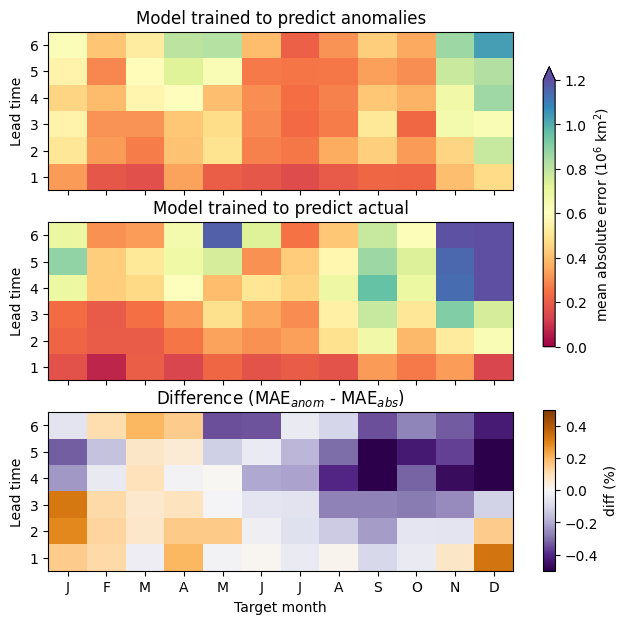

In [49]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,7), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

cax = axs[0].pcolormesh(x, y, mae_by_month_and_lead_anom.T, cmap='Spectral', shading='flat', vmin=0, vmax=1.2)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title("Model trained to predict anomalies")

axs[1].pcolormesh(x, y, mae_by_month_and_lead_abs.T, cmap='Spectral', shading='flat', vmin=0, vmax=1.2)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("Model trained to predict actual")

cax2 = axs[2].pcolormesh(x, y, (mae_by_month_and_lead_anom-mae_by_month_and_lead_abs).T, cmap='PuOr_r', \
    shading='flat', vmin=-0.5, vmax=0.5)
axs[2].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2].set_ylabel("Lead time")
axs[2].set_xlabel("Target month")
axs[2].set_title(r"Difference (MAE$_{anom}$ - MAE$_{abs}$)")


cbar_ax = fig.add_axes([0.95, 0.43, 0.02, 0.4])
cbar_ax2 = fig.add_axes([0.95, 0.11, 0.02, 0.23])
plt.colorbar(cax, cax=cbar_ax, label=r'mean absolute error (10$^6$ km$^2$)', orientation='vertical', extend='max')
plt.colorbar(cax2, cax=cbar_ax2, label=r'diff (%)', orientation='vertical')

#plt.savefig("../figures/anomaly_vs_abs_pred_forecast_MAE.jpg", dpi=300, bbox_inches='tight')

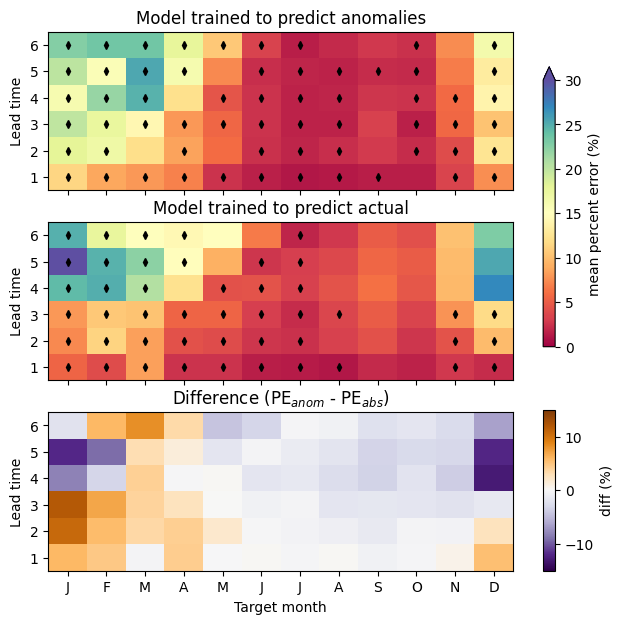

In [120]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,7), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

exceeds_persistence = nmae_by_month_and_lead_anom < nmae_by_month_and_lead_persist
cax = axs[0].pcolormesh(x, y, 100 * nmae_by_month_and_lead_anom.T, cmap='Spectral', shading='flat', vmin=0, vmax=30)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title("Model trained to predict anomalies")

for i in range(12):
    for j in range(6):
        if exceeds_persistence[i, j]:
            axs[0].plot(x_centers[i], y_centers[j], 'dk', markersize=4) 

exceeds_persistence = nmae_by_month_and_lead_abs < nmae_by_month_and_lead_persist
axs[1].pcolormesh(x, y, 100 * nmae_by_month_and_lead_abs.T, cmap='Spectral', shading='flat', vmin=0, vmax=30)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("Model trained to predict actual")
for i in range(12):
    for j in range(6):
        if exceeds_persistence[i, j]:
            axs[1].plot(x_centers[i], y_centers[j], 'dk', markersize=4) 

cax2 = axs[2].pcolormesh(x, y, 100 * (nmae_by_month_and_lead_anom-nmae_by_month_and_lead_abs).T, cmap='PuOr_r', \
    shading='flat', vmin=-15, vmax=15)
axs[2].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2].set_ylabel("Lead time")
axs[2].set_xlabel("Target month")
axs[2].set_title(r"Difference (PE$_{anom}$ - PE$_{abs}$)")


cbar_ax = fig.add_axes([0.95, 0.43, 0.02, 0.4])
cbar_ax2 = fig.add_axes([0.95, 0.11, 0.02, 0.23])
plt.colorbar(cax, cax=cbar_ax, label=r'mean percent error (%)', orientation='vertical', extend='max')
plt.colorbar(cax2, cax=cbar_ax2, label=r'diff (%)', orientation='vertical')

plt.savefig("../figures/anomaly_vs_abs_pred_forecast_percent_error.jpg", dpi=300, bbox_inches='tight')

/tmp/ipykernel_17357/2314589547.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Loss')

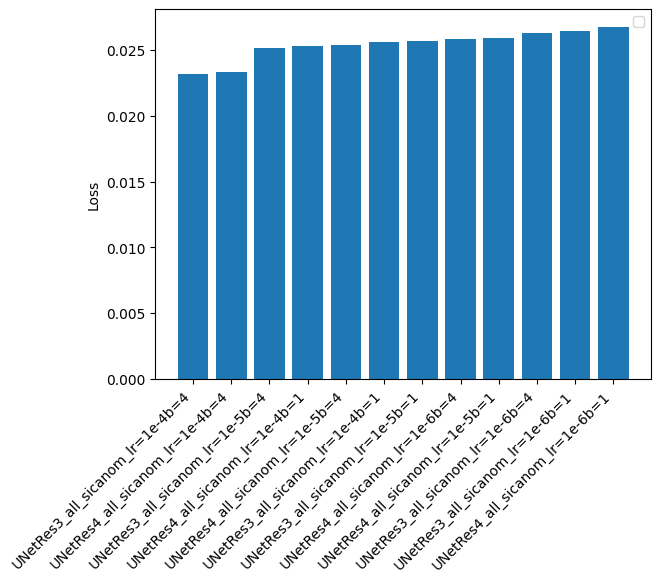

In [3]:
val_losses = {}
for arch in ["UNetRes4", "UNetRes3"]:
    for lr in [1e-4, 1e-5, 1e-6]:
        for batch_size in [1, 4]:
            # set hyperparams
            if lr == 1e-4: lr_str = "1e-4"
            if lr == 1e-5: lr_str = "1e-5"
            if lr == 1e-6: lr_str = "1e-6"
            model_name = f"{arch}_all_sicanom_lr={lr_str}b={batch_size}"

            model_config_dict = load_pickle(f"{DATA_DIRECTORY}/sicpred/models/{model_name}.pkl")
            val_losses[model_name] = model_config_dict["best_val_loss"]

sorted_val_losses = sorted(val_losses.items(), key=lambda item: item[1])
labels, values = zip(*sorted_val_losses)

plt.bar(labels, values)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.ylabel("Loss")


# 